In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import nltk
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

/Users/ujjwalkohli/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nlp=spacy.load('en_core_web_sm')

In [3]:
data=pd.read_csv('bbc_news_20220307_20240703 2.csv')
data.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


## Understanding the data

In [4]:
data.shape

(35860, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35860 entries, 0 to 35859
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        35860 non-null  object
 1   pubDate      35860 non-null  object
 2   guid         35860 non-null  object
 3   link         35860 non-null  object
 4   description  35860 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [6]:
data.isnull().sum()

title          0
pubDate        0
guid           0
link           0
description    0
dtype: int64

In [7]:
data['description'][0]

'The Ukrainian president says the country will not forgive or forget those who murder its civilians.'

## Cleaning and preprocessing the text

In [23]:
def preprocessed_text(text):
    text = re.sub(r'\W', ' ', text) #Replacing any character that is not a word or a digit or underscore with ''.
    text=text.lower() #Converts all the words to lower case
    lemma=[]
    doc=nlp(text)
    #doc=nlp(' '.join(text))
    not_stop=[token.text for token in doc if not token.is_stop]
    filtered_description = nlp(' '.join(not_stop))
    #for token in doc:
    #    lemma.append(token.lemma_)
    
    
    for token in filtered_description:
        lemma.append(token.lemma_)
    
    text1=' '.join(lemma)
    return text1
    

In [24]:
data['description'][2]

"One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies."

In [25]:
preprocessed_text(data['description'][2])

'world s big fertiliser firm say conflict deliver shock food supply'

In [26]:
#Applying it on the dataset
data['cleaned_description']=data['description'].apply(preprocessed_text)

In [27]:
data.head()

,title,pubDate,guid,link,description,cleaned_description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,ukrainian president say country forgive forget...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",jeremy bowen frontline irpin resident come ...
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,world s big fertiliser firm say conflict deliv...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,parent manchester arena bombing s young victim...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,consumer feel impact high energy cost fuel pri...


## Using VADER for finding the sentiment of each Description

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [29]:
sia=SentimentIntensityAnalyzer()

In [30]:
sia.polarity_scores(data['description'][2])

{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.5994}

In [31]:
# The compound score is what we need

In [32]:
def sentiment_score(text):
    score=sia.polarity_scores(text)['compound']
    return score

In [33]:
sentiment_score(data['cleaned_description'][0])

-0.6705

In [34]:
data['sentiment_score']=data['cleaned_description'].apply(sentiment_score)

In [35]:
data.head()

,title,pubDate,guid,link,description,cleaned_description,sentiment_score
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,ukrainian president say country forgive forget...,-0.6705
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",jeremy bowen frontline irpin resident come ...,-0.3400
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,world s big fertiliser firm say conflict deliv...,-0.5994
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,parent manchester arena bombing s young victim...,-0.7184
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,consumer feel impact high energy cost fuel pri...,0.2732


/Users/ujjwalkohli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='sentiment_score', ylabel='Density'>

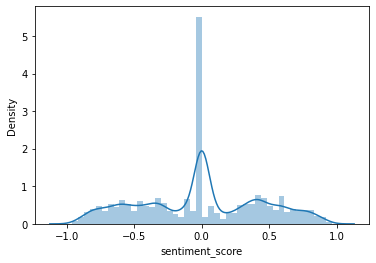

In [36]:
sns.distplot(data['sentiment_score'])

In [37]:
#Checking for normality of the scores

In [38]:
import scipy.stats as stats

In [39]:
stats.shapiro(data['sentiment_score'])

/Users/ujjwalkohli/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9695925712585449, pvalue=0.0)

In [40]:
#Since the P-value of the test is 0, we Reject the null hypothesis.

In [41]:
#creating a category for the positive and the negative sentiments

In [42]:
data['Category']=data['sentiment_score'].apply(lambda x: 'Pos' if x>0 else ('Neg' if x<0 else 'Neu'))

<AxesSubplot: >

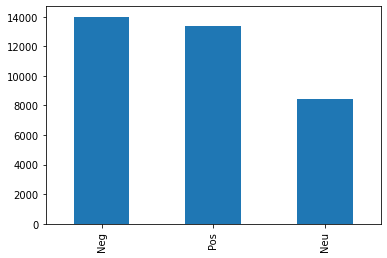

In [43]:
data['Category'].value_counts().plot(kind='bar')

In [44]:
data['Category'].value_counts()

Neg    13997
Pos    13399
Neu     8464
Name: Category, dtype: int64

In [45]:
# The dataset loooks nicely balanced for model building

## Encoding the target variable

### Encoding the category manually

In [46]:
data['Encoded_category'] = data['Category'].apply(lambda x: '0' if x=='Neu' else ('1' if x=='Pos' else '2'))

In [47]:
data['Encoded_category'].value_counts()

2    13997
1    13399
0     8464
Name: Encoded_category, dtype: int64

- 1 = Positive Sentiment
- 2 = Negative Sentiment
- 0 = Neutral Sentiment

## Train Test Split

In [48]:
x=data['cleaned_description']
y=data['Encoded_category']

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42)

In [49]:
xtrain.shape

(25102,)

In [50]:
xtest.shape

(10758,)

## Transforming the description column

In [51]:
# Using the TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
xtrain_transform=tfidf.fit_transform(xtrain)
xtest_transform=tfidf.transform(xtest)

In [53]:
xtrain_transform

<25102x11413 sparse matrix of type '<class 'numpy.float64'>'
	with 241939 stored elements in Compressed Sparse Row format>

## Model Building

### Building a Support vector Machine classifier

In [54]:
svc=SVC(C=2,kernel='linear')
model=svc.fit(xtrain_transform,ytrain)
#------------------------------------
svc_prediction=model.predict(xtest_transform)

In [55]:
print(classification_report(ytest,svc_prediction))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2585
           1       0.91      0.89      0.90      4052
           2       0.93      0.88      0.90      4121

    accuracy                           0.90     10758
   macro avg       0.89      0.90      0.90     10758
weighted avg       0.90      0.90      0.90     10758



In [56]:
print(accuracy_score(ytest,svc_prediction))

0.8968209704406024


In [57]:
svc=SVC(kernel='rbf')
model=svc.fit(xtrain_transform,ytrain)
#------------------------------------
svc_prediction=model.predict(xtest_transform)

print(classification_report(ytest,svc_prediction))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2585
           1       0.88      0.85      0.86      4052
           2       0.89      0.86      0.87      4121

    accuracy                           0.86     10758
   macro avg       0.85      0.86      0.85     10758
weighted avg       0.86      0.86      0.86     10758



In [58]:
#Trying out RandomForest Algorithm

In [59]:
rf=RandomForestClassifier(n_estimators=90)

model=rf.fit(xtrain_transform,ytrain)

rf_prediction=model.predict(xtest_transform)

print(classification_report(ytest,rf_prediction))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2585
           1       0.86      0.86      0.86      4052
           2       0.91      0.82      0.86      4121

    accuracy                           0.86     10758
   macro avg       0.85      0.87      0.86     10758
weighted avg       0.86      0.86      0.86     10758



## Creating a pipeline 

In [60]:
from sklearn.pipeline import Pipeline

In [61]:
proj_pipeline = Pipeline([('tfidf',TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')),('svc',SVC(C=2,kernel='linear'))])

In [62]:
proj_pipeline.fit(xtrain,ytrain)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('svc', SVC(C=2, kernel='linear'))])

In [63]:
new_sentence="In a small, close-knit town, a tragic incident has left the community heartbroken. Last night, a devastating fire engulfed an entire neighborhood, resulting in the loss of several homes and displacing numerous families. Among the victims were children and elderly residents who struggled to escape the fast-spreading flames. Emergency responders worked tirelessly through the night, but the extent of the damage has left many in despair. The cause of the fire is still under investigation, but the emotional toll on the survivors is immeasurable. The town has come together in mourning, offering support and shelter to those affected, but the scars of this tragedy will be felt for years to come."

In [64]:
preprocessed_sentence=preprocessed_text(new_sentence)

In [65]:
proj_pipeline.predict([preprocessed_sentence])

array(['2'], dtype=object)

In [66]:
# The model has correctly predicted the article description as negative.